# I. Introduction

## Imports

In [1]:
import re
import string
import unicodedata
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import plotly.express as px 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from IPython.display import display, HTML

from bs4 import BeautifulSoup
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Importing NLTK

In [2]:
import nltk

from nltk import pos_tag

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import (
    word_tokenize, 
    sent_tokenize
)

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing Sklearn

In [3]:
from sklearn.metrics import (
    accuracy_score,
    classification_report, 
    confusion_matrix
)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

### Importing Keras

In [4]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.layers import (
    Dense, 
    Dropout, 
    Embedding, 
    LSTM
)
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences

In [119]:
!pip3 install catboost


from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import tensorflow as tf

### Installing VisualKeras

In [6]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

import visualkeras

import warnings; warnings.simplefilter('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-6jlif964
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-6jlif964
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


## Dataset and Origin


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 


genuine_news_articles = pd.read_csv("/content/drive/MyDrive/Datasets/FakeNews/True.csv")
fake_news_articles = pd.read_csv("/content/drive/MyDrive/Datasets/FakeNews/Fake.csv")

Mounted at /content/drive


## Dataset Ethics

## Dataset Description

In [8]:
genuine_news_articles.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [9]:
fake_news_articles.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [10]:
genuine_news_articles['category'] = 1
fake_news_articles['category'] = 0

# II. Methodology and Pipeline - Generalization

### Merging Fake and True Datasets

In [11]:
genuine_news_articles['target'] = 1
fake_news_articles['target'] = 0

genuine_and_fake_news_df = pd.concat([
    genuine_news_articles,
    fake_news_articles
])

genuine_and_fake_news_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
23476  21st Century Wire says As 21WIRE reported earl...   Middle-east   
23477  21st Century Wire says It s a familiar theme. ...   Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
23479  21st Century Wire says Al Jazeera America will...   Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  category  target  
0      December 31, 2017          1       1  
1      December 29, 2017          1       1  
2      December 31, 2017          1       1  
3      December 30, 2017          1       1  
4      December 29, 2017          1       1  
...                   ...       ...     ...  
23476    January 16, 2016         0       0  
23477    January 16, 2016         0       0  
23478    January 15, 2016         0       0  
23479    January 14, 2016         0       0  
23480    January 12, 2016         0       0  

[44898 rows x 6 columns]

In [12]:
# plt.figure(figsize=(10,10))

# sns.countplot(genuine_and_fake_news_df.category, palette="mako")

# plt.xlabel("CATEGORIES", fontsize = 16)
# plt.ylabel("TOTAL", fontsize = 16)
# plt.show()

In [13]:
count_news_articles_by_subject = genuine_and_fake_news_df.groupby('subject').apply(
    lambda x:x['title'].count()
).reset_index(name='Counts')


count_news_articles_by_subject_figure = px.bar(
    count_news_articles_by_subject, 
    x="subject",
    y="Counts",
    color='Counts', 
    barmode='group',
    title='Count of News Articles by Subject',
    height=800
)
count_news_articles_by_subject_figure.show()

In [14]:
genuine_and_fake_news_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  target  
0  December 31, 2017          1       1  
1  December 29, 2017          1       1  
2  December 31, 2017          1       1  
3  December 30, 2017          1       1  
4  December 29, 2017          1       1

### Check for NaN

In [15]:
genuine_and_fake_news_df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
target      0
dtype: int64

In [16]:
genuine_and_fake_news_df.title.count()

44898

In [17]:
genuine_and_fake_news_df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**MERGING ALL THE TEXT DATA INTO 1 COLUMN i.e. 'text'**

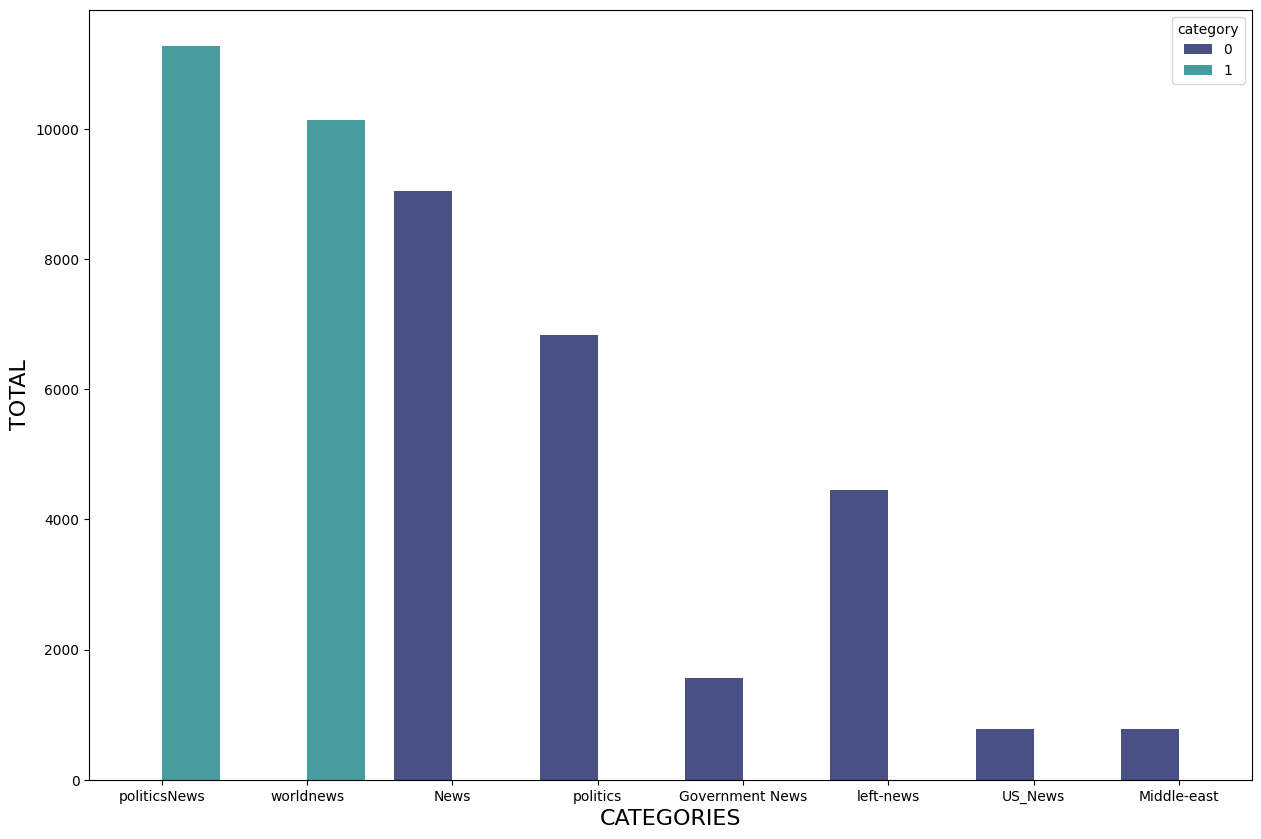

In [18]:
plt.figure(figsize = (15, 10))

sns.countplot(
    x="subject", 
    hue="category", 
    data=genuine_and_fake_news_df, 
    palette="mako"
)

plt.xlabel("CATEGORIES", fontsize = 16)
plt.ylabel("TOTAL", fontsize = 16)
plt.show()

In [19]:
genuine_and_fake_news_df['text'] = (
    genuine_and_fake_news_df['text'] + 
    " " + 
    genuine_and_fake_news_df['title']
)

### Data Cleaning Pipeline

In [20]:
class CleanData():

    def remove_html_code(self, text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    def remove_within_brackets(self, text):
        return re.sub('\[[^]]*\]', '', text)

    def remove_stopwords(self, text):
        
        common_words = set(stopwords.words('english'))
        common_words.update(list(string.punctuation))

        final_words = []

        for _text in text.split():

            stripped_text = _text.strip()

            if stripped_text.lower() not in common_words:
                final_words.append(stripped_text)

        return " ".join(final_words)

In [21]:
def data_cleaning_pipeline(text):
    """Data Cleaning Pipleline, takes in cleaned data from one method, and sends it to other methods."""

    clean_data_handler = CleanData()

    # Removing HTML Code
    cleaned_text = clean_data_handler.remove_html_code(text)

    # Removing Within Square Brackets
    cleaned_text = clean_data_handler.remove_within_brackets(cleaned_text)

    # Removing Stop Words using NLTK.
    cleaned_text = clean_data_handler.remove_stopwords(cleaned_text)

    # We can add any number of functions to the pipeline.

    return cleaned_text

In [22]:
genuine_and_fake_news_df['text'] = genuine_and_fake_news_df['text'].apply(
    data_cleaning_pipeline
)

In [23]:
def black_text_wordcloud(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
    
visual_word_cloud = WordCloud(
    background_color="white", 
    max_words=2000, 
    width=1600,
    height=800, 
    stopwords = STOPWORDS
)

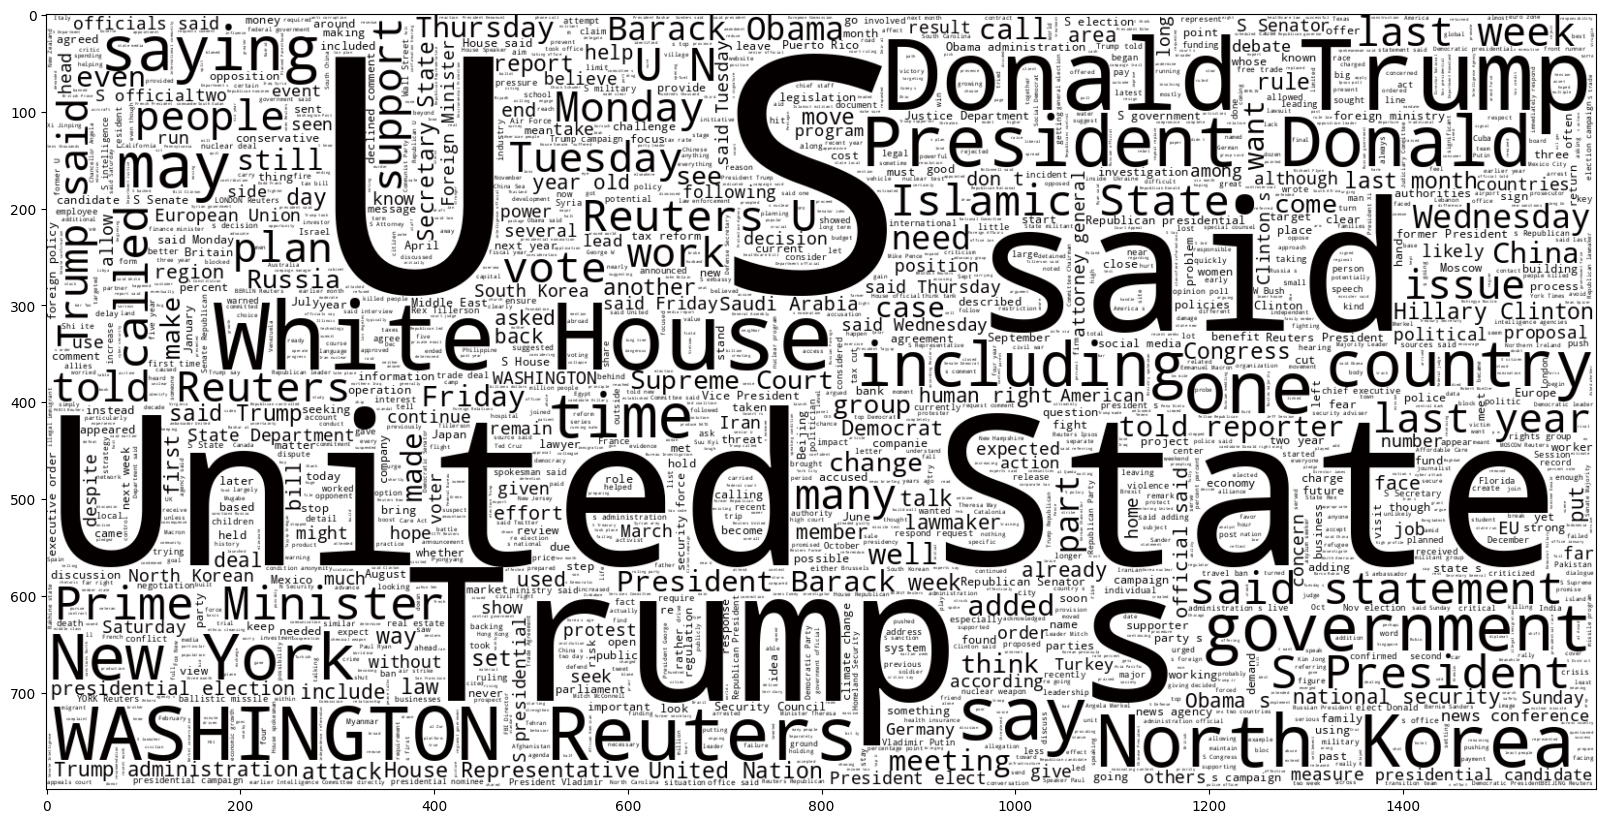

In [24]:
plt.figure(figsize = (20,20)) # Text that is Genuine

visual_word_cloud.generate(
    " ".join(
      genuine_and_fake_news_df[genuine_and_fake_news_df.category == 1].text
    )
)
visual_word_cloud.recolor(color_func=black_text_wordcloud)
plt.imshow(visual_word_cloud, interpolation = 'bilinear')

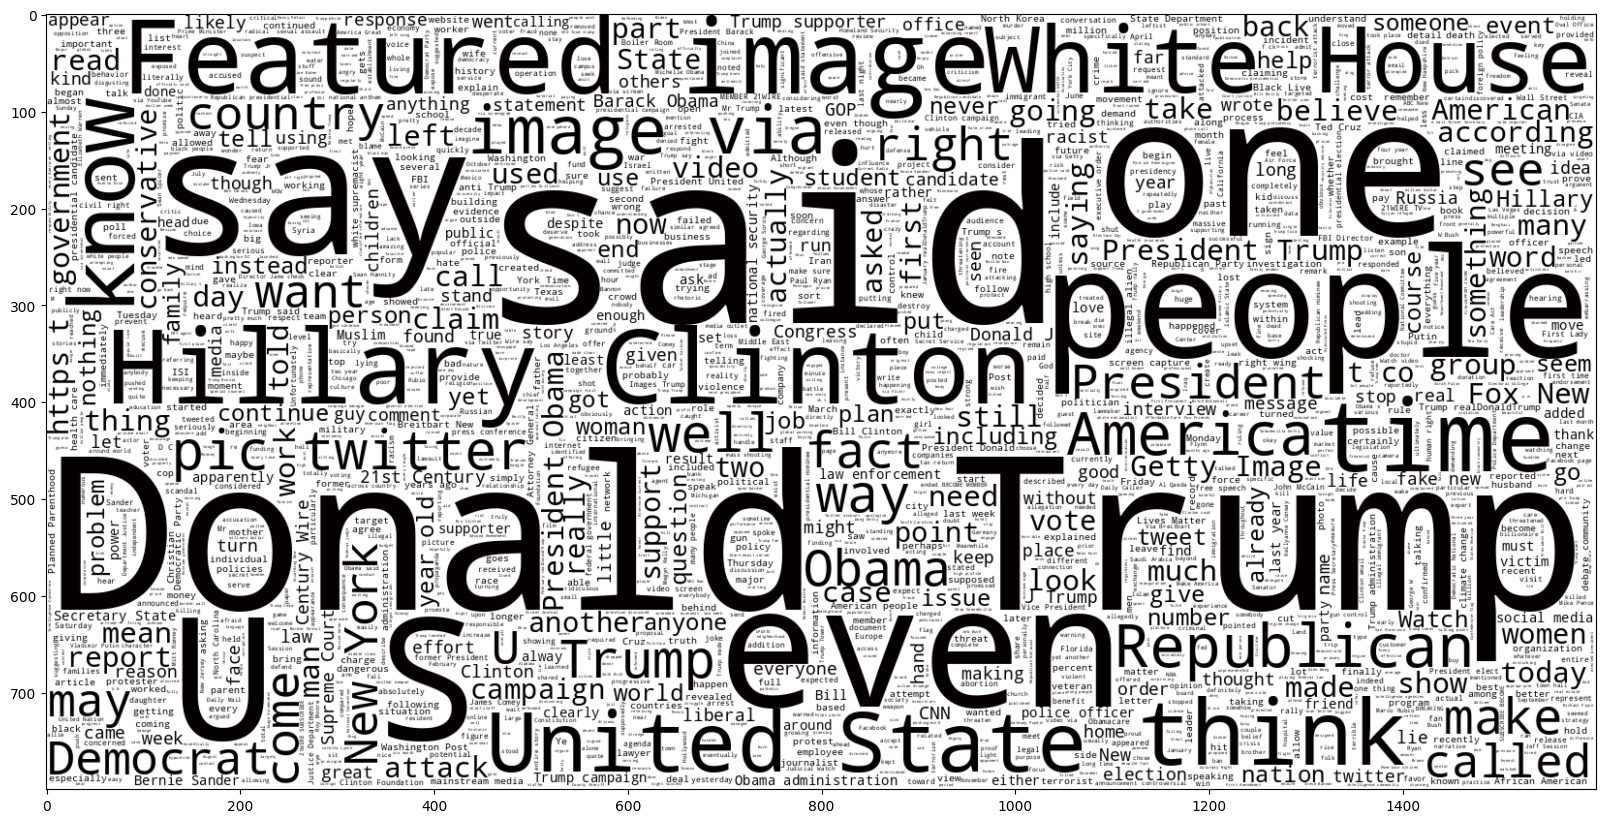

In [25]:
plt.figure(figsize = (20,20)) # Text that is Fake

visual_word_cloud.generate(
    " ".join(
      genuine_and_fake_news_df[genuine_and_fake_news_df.category == 0].text
    )
)
visual_word_cloud.recolor(color_func=black_text_wordcloud)
plt.imshow(visual_word_cloud , interpolation = 'bilinear')

### Distribution of Subjects between the Genuine and Fake News



In [26]:
distribution_subjects_genuine_fake_news = genuine_and_fake_news_df.groupby('target').apply(
    lambda x:x['title'].count()
).reset_index(name='Counts')

distribution_subjects_genuine_fake_news.target.replace(
    {0:'Fake News',1:'Genuine News'}, inplace=True
)

distribution_subjects_genuine_fake_news_figure = px.bar(
    distribution_subjects_genuine_fake_news, 
    x="target",
    y="Counts",
    color='Counts', 
    barmode='group',
    height=800
)
distribution_subjects_genuine_fake_news_figure.show()

Thus, we can observe that the dataset appears to be balanced.

In [27]:
def get_corpus(text):
    """Adds all the text for using in CountVectorizer"""
    words = []

    for _text in text:

        for split_text in _text.split():

            words.append(split_text.strip())

    return words

In [28]:
corpus_count = Counter(
    get_corpus(genuine_and_fake_news_df.text)
)

common_words = dict(
    corpus_count.most_common(10)
)

In [29]:
def get_top_text_ngrams(text_corpus, n, gram):

    count_vectorizer = CountVectorizer(ngram_range=(gram, gram)).fit(text_corpus)

    bag_of_words = count_vectorizer.transform(text_corpus)

    sum_words = bag_of_words.sum(axis=0) 

    frequency_words = [(text, sum_words[0, index]) for text, index in count_vectorizer.vocabulary_.items()]

    frequency_words = sorted(frequency_words, key = lambda x: x[1], reverse=True)

    return frequency_words[:n]

<Axes: >

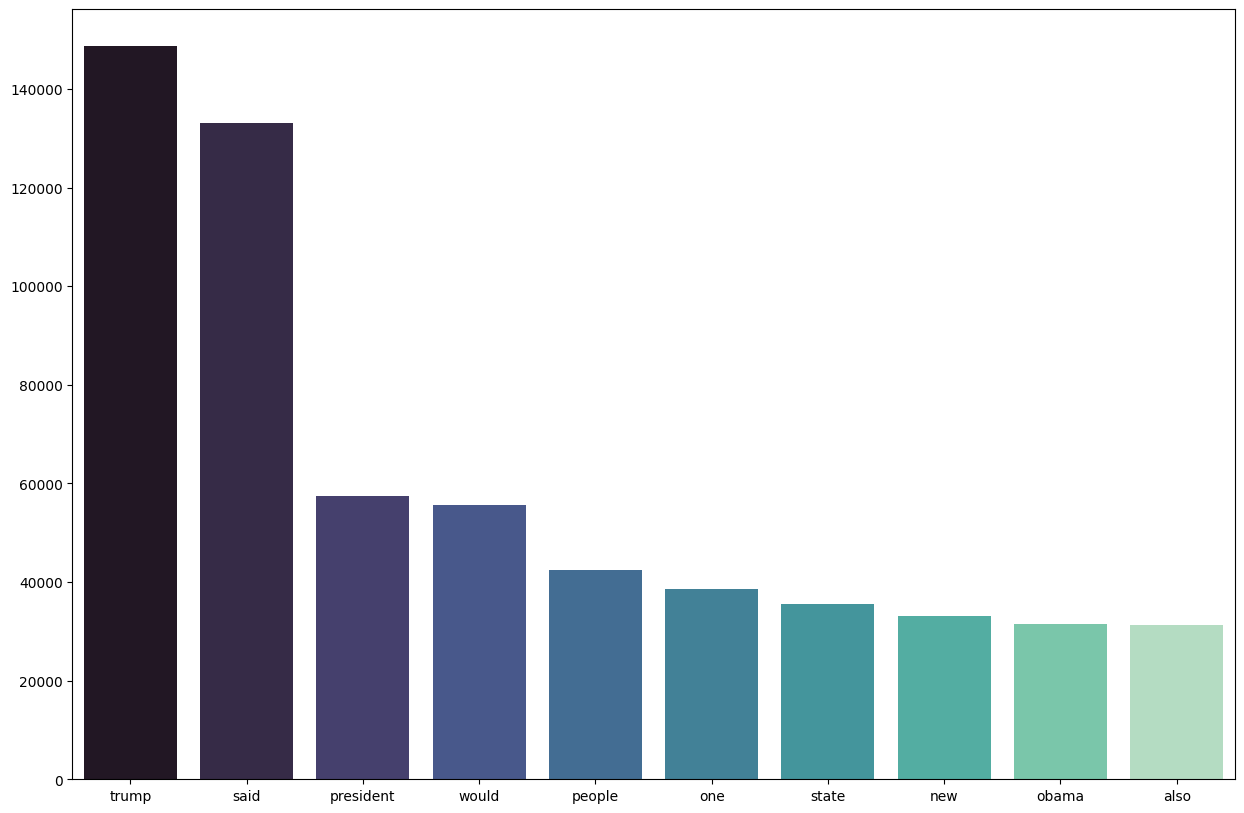

In [30]:
plt.figure(figsize = (15, 10))

common_unigrams = get_top_text_ngrams(
    genuine_and_fake_news_df.text, 10, 1
)

common_unigrams = dict(common_unigrams)

common_unigrams_keys = common_unigrams.keys()
common_unigrams_values = common_unigrams.values()

sns.barplot(
    x=list(common_unigrams_keys),
    y=list(common_unigrams_values), 
    palette="mako"
)

<Axes: >

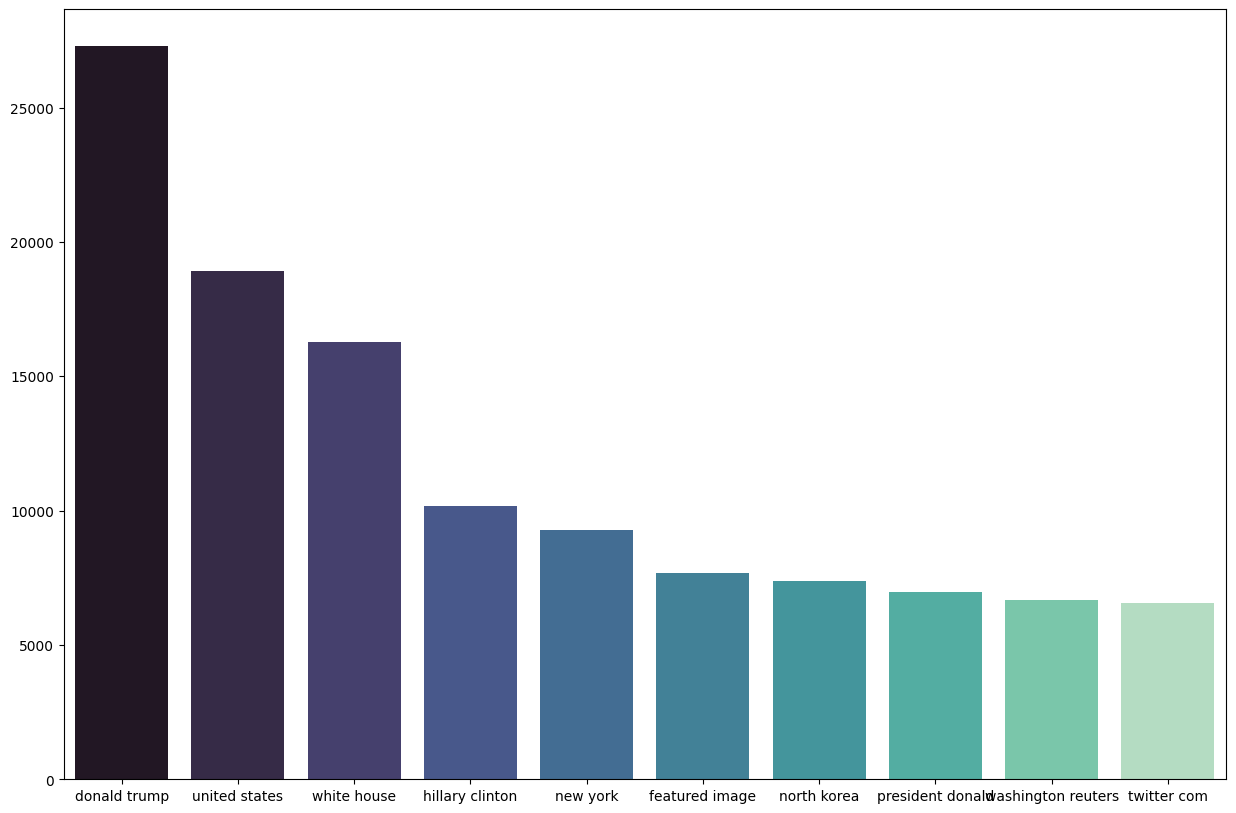

In [31]:
plt.figure(figsize = (15, 10))

common_bigrams = get_top_text_ngrams(
    genuine_and_fake_news_df.text, 10, 2
)

common_bigrams = dict(common_bigrams)

common_bigrams_keys = common_bigrams.keys()
common_bigrams_values = common_bigrams.values()

sns.barplot(
    x=list(common_bigrams_keys),
    y=list(common_bigrams_values), 
    palette="mako"
)

<Axes: >

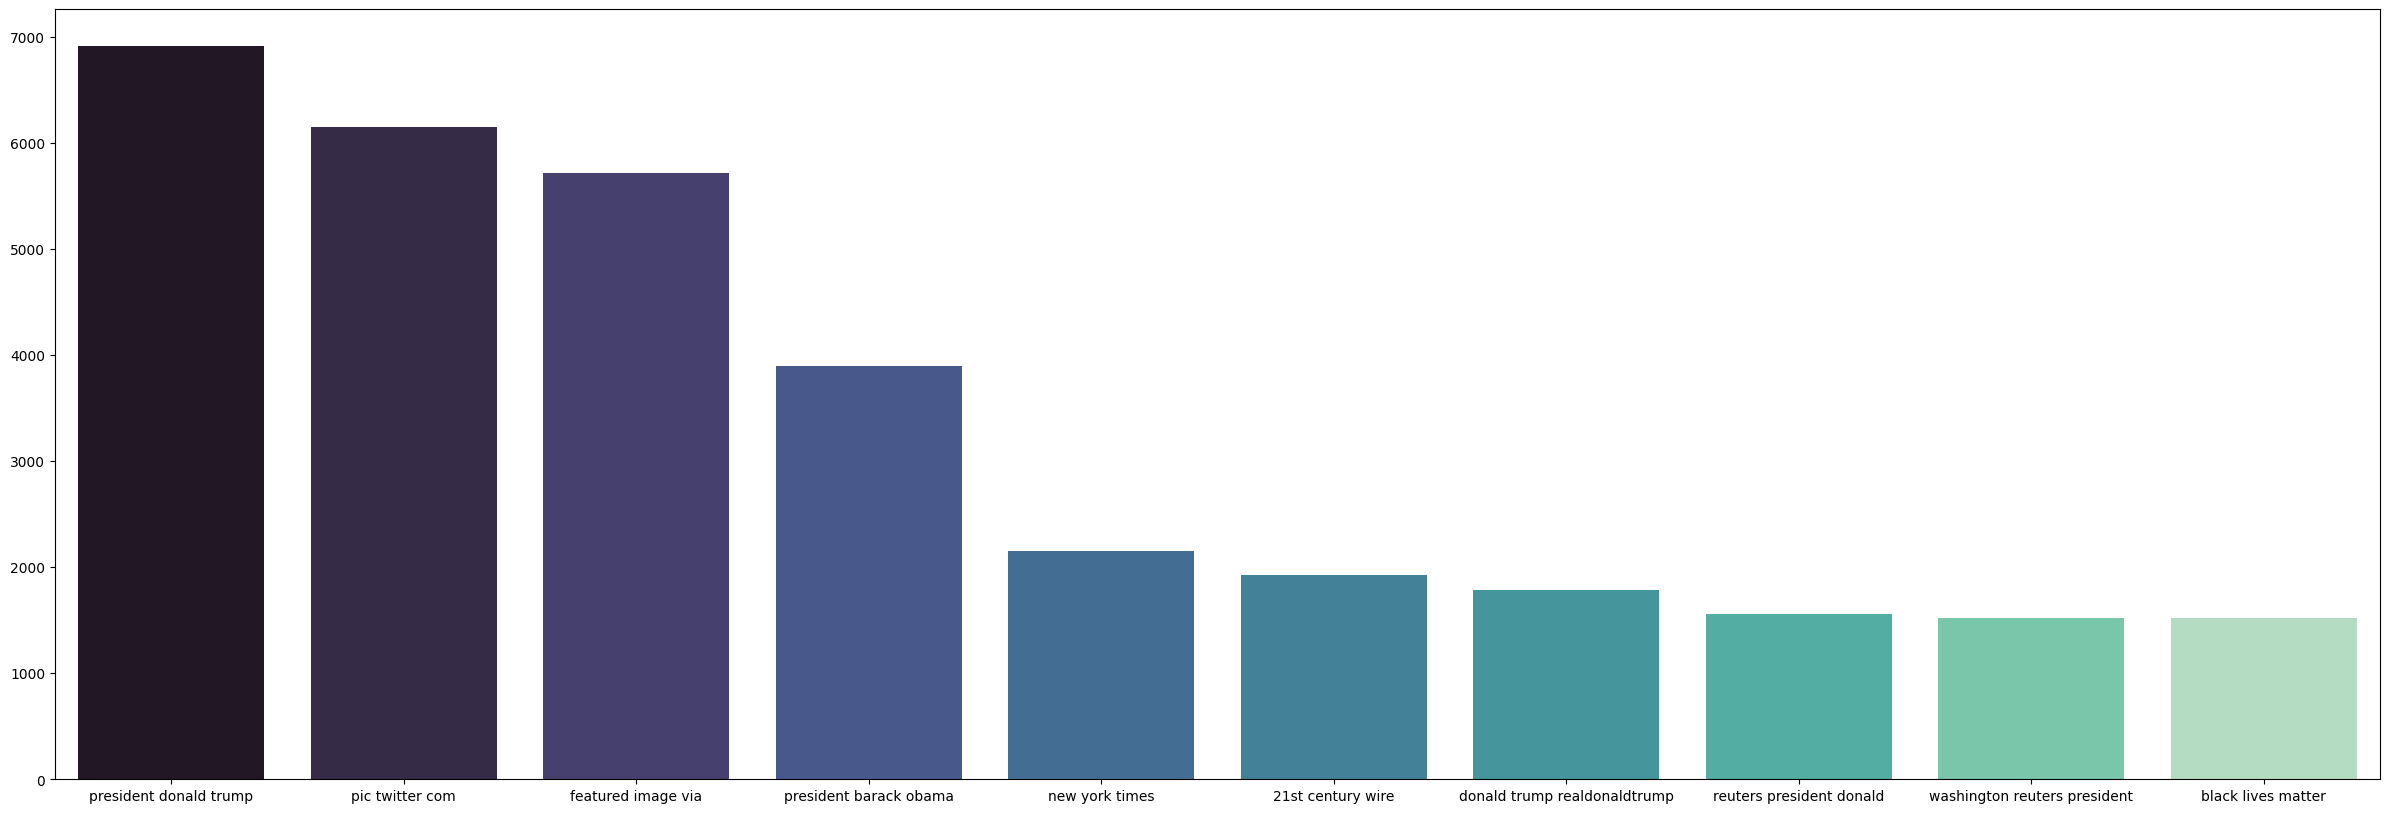

In [32]:
plt.figure(figsize = (30, 10))

common_trigrams = get_top_text_ngrams(
    genuine_and_fake_news_df.text, 10, 3
)

common_trigrams = dict(common_trigrams)

common_trigrams_keys = common_trigrams.keys()
common_trigrams_values = common_trigrams.values()

sns.barplot(
    x=list(common_trigrams_keys),
    y=list(common_trigrams_values), 
    palette="mako"
)

## Feature Engineering

In [33]:
data = genuine_and_fake_news_df.reset_index()
data = data.sample(frac=1) 

In [34]:
data.duplicated().sum()


0

In [35]:
data = data.drop(['date', 'subject'], axis=1)

In [36]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop('category', axis=1)
y_train = train['category']
X_test = test.drop('category', axis=1)
y_test = test['category']

In [37]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

In [38]:
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6           us
7    president
8      clinton
9         will
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0     trump
1        us
2      says
3     house
4     north
5       new
6     white
7    russia
8     korea
9    senate
Name: 0, dtype: object


In [39]:
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

def frequent_keywords(data, attribute, label):
    column_data = data[attribute].str.lower()
    combined_text = ' '.join(column_data)
    exclude_punctuation = set(string.punctuation)
    filtered_text = ''.join(character for character in combined_text if character not in exclude_punctuation)
    split_words = filtered_text.split()
    filtered_words = [word for word in split_words if not word in stopwords]
    print(f'{label}:\n{pd.DataFrame(nltk.FreqDist(filtered_words).most_common(10))[0]}')

frequent_keywords(train_news, 'title', 'Top keywords in Real News Titles')
print('\n')
frequent_keywords(train_fake, 'title', 'Top keywords in Fake News Titles')


Top keywords in Real News Titles:
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6           us
7    president
8      clinton
9         will
Name: 0, dtype: object


Top keywords in Fake News Titles:
0     trump
1        us
2      says
3     house
4     north
5       new
6     white
7    russia
8     korea
9    senate
Name: 0, dtype: object


In [40]:
import regex as re

# Function to calculate punctuation count in the given text
def punctuation_count(input_text):
    period_count = re.subn(r"\.", '', input_text)[1]
    comma_count = re.subn(r"\,", '', input_text)[1]
    question_count = re.subn(r"\?", '', input_text)[1]
    exclamation_count = re.subn(r"\!", '', input_text)[1]
    punctuation_counts = [period_count, comma_count, question_count, exclamation_count]
    return punctuation_counts

# Count punctuation in the sample text
punctuation_counts_result = punctuation_count('...alph!a.beta.gamma...??')
print(f'Punctuation counts: Periods={punctuation_counts_result[0]}, Commas={punctuation_counts_result[1]}, Question marks={punctuation_counts_result[2]}, Exclamation marks={punctuation_counts_result[3]}')


Punctuation counts: Periods=8, Commas=0, Question marks=2, Exclamation marks=1


In [41]:
def generate_punctuation_dataframe(data, column_name):
    return data.apply(lambda row: pd.Series({
        'periods_' + column_name: punctuation_count(row[column_name])[0], 
        'commas_' + column_name: punctuation_count(row[column_name])[1],
        'questions_' + column_name: punctuation_count(row[column_name])[2],
        'exclamations_' + column_name: punctuation_count(row[column_name])[3]
    }), axis=1)

train_punctuation_title = generate_punctuation_dataframe(train, 'title')
test_punctuation_title = generate_punctuation_dataframe(test, 'title')
train_punctuation_text = generate_punctuation_dataframe(train, 'text')
test_punctuation_text = generate_punctuation_dataframe(test, 'text')
print(train_punctuation_text)

       periods_text  commas_text  questions_text  exclamations_text
18403             5            6               0                  0
6516             22           20               0                  0
38851             6            3               0                  0
11425            16           23               0                  0
33954            11           16               0                  0
...             ...          ...             ...                ...
34333             0            0               0                  0
12540             2            4               0                  0
13074            14            2               0                  0
14638            17           13               0                  0
10929            17           29               0                  0

[35918 rows x 4 columns]


In [42]:
train_punctuation_text

periods_text  commas_text  questions_text  exclamations_text
18403             5            6               0                  0
6516             22           20               0                  0
38851             6            3               0                  0
11425            16           23               0                  0
33954            11           16               0                  0
...             ...          ...             ...                ...
34333             0            0               0                  0
12540             2            4               0                  0
13074            14            2               0                  0
14638            17           13               0                  0
10929            17           29               0                  0

[35918 rows x 4 columns]

In [43]:
def generate_length_dataframe(data):
    return data.apply(lambda row: pd.Series({
        'title_length': len(row['title']),
        'text_length': len(row['text'])
    }), axis=1)

train_length = generate_length_dataframe(train)
test_length = generate_length_dataframe(test)

print(train_length)

       title_length  text_length
18403            68          469
6516             72         2128
38851            48          607
11425            69         2089
33954            88         1147
...             ...          ...
34333           111          131
12540            59          414
13074            69          759
14638            68         1927
10929            54         2058

[35918 rows x 2 columns]


In [44]:
def generate_word_count_dataframe(data):
    return data.apply(lambda row: pd.Series({
        'title_word_count': len(row['title'].split())
    }), axis=1)

train_word_count = generate_word_count_dataframe(train)
test_word_count = generate_word_count_dataframe(test)

print(train_word_count)

       title_word_count
18403                10
6516                  9
38851                 7
11425                11
33954                13
...                 ...
34333                15
12540                10
13074                11
14638                11
10929                 9

[35918 rows x 1 columns]


In [45]:
def generate_title_ratio_dataframe(data):
    return data.apply(lambda row: pd.Series({
        'title_length_ratio': len(row['title']) / (len(row['title']) + len(row['text']))
    }), axis=1)

train_title_ratio = generate_title_ratio_dataframe(train)
test_title_ratio = generate_title_ratio_dataframe(test)

print(train_title_ratio)

       title_length_ratio
18403            0.126629
6516             0.032727
38851            0.073282
11425            0.031974
33954            0.071255
...                   ...
34333            0.458678
12540            0.124736
13074            0.083333
14638            0.034085
10929            0.025568

[35918 rows x 1 columns]


In [46]:
X_train_punctuation_length = pd.concat([train_punctuation_title, 
                               train_punctuation_text, 
                               train_length, 
                               train_word_count, 
                               train_title_ratio], 
                              axis=1)

X_test_punctuation_length = pd.concat([test_punctuation_title, 
                               test_punctuation_text, 
                               test_length, 
                               test_word_count, 
                               test_title_ratio], 
                             axis=1)

X_train_punctuation_length

periods_title  commas_title  questions_title  exclamations_title  \
18403              0             0                0                   0   
6516               0             0                0                   0   
38851              0             0                0                   0   
11425              0             0                0                   0   
33954              0             0                0                   0   
...              ...           ...              ...                 ...   
34333              0             0                0                   0   
12540              0             0                0                   0   
13074              2             0                0                   0   
14638              0             0                0                   0   
10929              0             0                0                   0   

       periods_text  commas_text  questions_text  exclamations_text  \
18403             5            6               0                  0   
6516             22           20               0                  0   
38851             6            3               0                  0   
11425            16           23               0                  0   
33954            11           16               0                  0   
...             ...          ...             ...                ...   
34333             0            0               0                  0   
12540             2            4               0                  0   
13074            14            2               0                  0   
14638            17           13               0                  0   
10929            17           29               0                  0   

       title_length  text_length  title_word_count  title_length_ratio  
18403            68          469                10            0.126629  
6516             72         2128                 9            0.032727  
38851            48          607                 7            0.073282  
11425            69         2089                11            0.031974  
33954            88         1147                13            0.071255  
...             ...          ...               ...                 ...  
34333           111          131                15            0.458678  
12540            59          414                10            0.124736  
13074            69          759                11            0.083333  
14638            68         1927                11            0.034085  
10929            54         2058                 9            0.025568  

[35918 rows x 12 columns]

In [47]:
X_train_punctuation_length.describe()


periods_title  commas_title  questions_title  exclamations_title  \
count   35918.000000  35918.000000     35918.000000        35918.000000   
mean        0.273373      0.224010         0.042291            0.080350   
std         0.701101      0.496209         0.214903            0.300259   
min         0.000000      0.000000         0.000000            0.000000   
25%         0.000000      0.000000         0.000000            0.000000   
50%         0.000000      0.000000         0.000000            0.000000   
75%         0.000000      0.000000         0.000000            0.000000   
max         6.000000      5.000000         3.000000            4.000000   

       periods_text   commas_text  questions_text  exclamations_text  \
count  35918.000000  35918.000000    35918.000000       35918.000000   
mean      20.977922     20.283730        0.700345           0.473356   
std       17.653405     19.833482        1.659303           1.298889   
min        0.000000      0.000000        0.000000           0.000000   
25%       10.000000      8.000000        0.000000           0.000000   
50%       18.000000     17.000000        0.000000           0.000000   
75%       27.000000     27.000000        1.000000           0.000000   
max      366.000000    449.000000       34.000000          35.000000   

       title_length   text_length  title_word_count  title_length_ratio  
count  35918.000000  35918.000000      35918.000000        35918.000000  
mean      80.172949   1887.174369         12.461551            0.072746  
std       25.353115   1606.966358          4.103983            0.086695  
min       15.000000     30.000000          1.000000            0.000792  
25%       63.000000    982.000000         10.000000            0.030349  
50%       73.000000   1661.000000         11.000000            0.045569  
75%       91.000000   2350.000000         14.000000            0.079017  
max      286.000000  40192.000000         42.000000            0.659091

In [48]:
from scipy import stats

# Calculate z-scores for X_train_punctuation_length
X_train_punctuation_length_zscores = X_train_punctuation_length.apply(stats.zscore, axis=0)

# Create a mask for outliers where z-scores are greater than 5 or less than -5
outliers_mask = np.logical_not(((X_train_punctuation_length_zscores > 5).any(axis=1)).values + ((X_train_punctuation_length_zscores < -5).any(axis=1)).values)

# Apply the mask to filter out outliers
X_train_filtered = X_train_punctuation_length.loc[outliers_mask, :]

# Update y_train to match the filtered X_train
y_train_filtered = y_train[X_train_filtered.index]

# Print the filtered X_train
print(X_train_filtered)


       periods_title  commas_title  questions_title  exclamations_title  \
18403              0             0                0                   0   
6516               0             0                0                   0   
38851              0             0                0                   0   
11425              0             0                0                   0   
33954              0             0                0                   0   
...              ...           ...              ...                 ...   
34333              0             0                0                   0   
12540              0             0                0                   0   
13074              2             0                0                   0   
14638              0             0                0                   0   
10929              0             0                0                   0   

       periods_text  commas_text  questions_text  exclamations_text  \
18403             5         

In [49]:
X_train_punctuation_length.describe()


periods_title  commas_title  questions_title  exclamations_title  \
count   35918.000000  35918.000000     35918.000000        35918.000000   
mean        0.273373      0.224010         0.042291            0.080350   
std         0.701101      0.496209         0.214903            0.300259   
min         0.000000      0.000000         0.000000            0.000000   
25%         0.000000      0.000000         0.000000            0.000000   
50%         0.000000      0.000000         0.000000            0.000000   
75%         0.000000      0.000000         0.000000            0.000000   
max         6.000000      5.000000         3.000000            4.000000   

       periods_text   commas_text  questions_text  exclamations_text  \
count  35918.000000  35918.000000    35918.000000       35918.000000   
mean      20.977922     20.283730        0.700345           0.473356   
std       17.653405     19.833482        1.659303           1.298889   
min        0.000000      0.000000        0.000000           0.000000   
25%       10.000000      8.000000        0.000000           0.000000   
50%       18.000000     17.000000        0.000000           0.000000   
75%       27.000000     27.000000        1.000000           0.000000   
max      366.000000    449.000000       34.000000          35.000000   

       title_length   text_length  title_word_count  title_length_ratio  
count  35918.000000  35918.000000      35918.000000        35918.000000  
mean      80.172949   1887.174369         12.461551            0.072746  
std       25.353115   1606.966358          4.103983            0.086695  
min       15.000000     30.000000          1.000000            0.000792  
25%       63.000000    982.000000         10.000000            0.030349  
50%       73.000000   1661.000000         11.000000            0.045569  
75%       91.000000   2350.000000         14.000000            0.079017  
max      286.000000  40192.000000         42.000000            0.659091

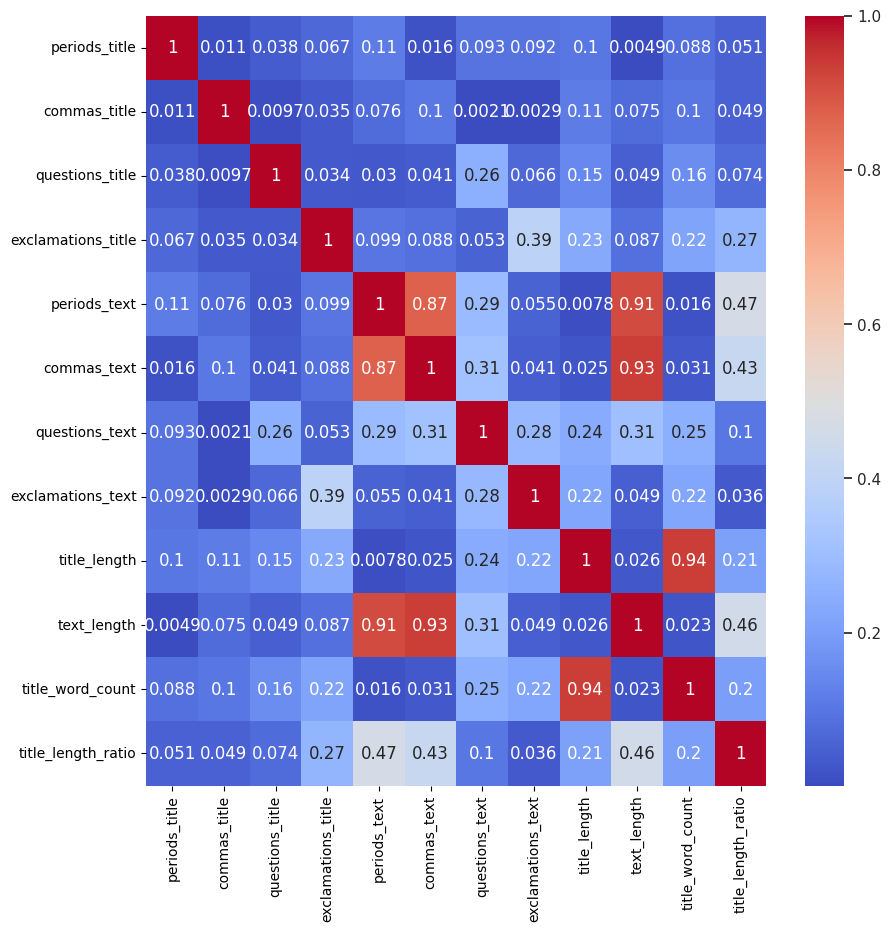

In [50]:
import seaborn as sns
figure, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid")  # Set the style for the plot
sns.heatmap(np.abs(X_train_punctuation_length.corr()), annot=True, cmap="coolwarm")  # Use the "coolwarm" color palette
plt.savefig('correlation')
plt.show()

In [51]:
pd.concat([X_train_punctuation_length, y_train], axis=1).groupby('category').mean()



periods_title  commas_title  questions_title  exclamations_title  \
category                                                                     
0              0.096352      0.199830         0.074870            0.152611   
1              0.467917      0.250584         0.006487            0.000935   

          periods_text  commas_text  questions_text  exclamations_text  \
category                                                                 
0            20.755238    21.030682        1.242848           0.846113   
1            21.222651    19.462833        0.104137           0.063698   

          title_length  text_length  title_word_count  title_length_ratio  
category                                                                   
0            94.236148  1912.935659         14.731256            0.087796  
1            64.717567  1858.862845          9.967158            0.056207

## 1. RNN Model using Word2Vector

In [52]:
X_processed = []
stopwords = set(nltk.corpus.stopwords.words("english"))
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for paragraph in genuine_and_fake_news_df['text'].values:
    temp = []
    sentence_list = nltk.sent_tokenize(paragraph)
    for sentence in sentence_list:
        sentence = sentence.lower()
        word_tokens = word_tokenizer.tokenize(sentence)
        filtered_tokens = [word.strip() for word in word_tokens if word not in stopwords and len(word) > 1]
        temp.extend(filtered_tokens)
    X_processed.append(temp)


In [53]:
import gensim


In [54]:
embedding_dimensions = 100

word2vector = gensim.models.Word2Vec(
    sentences=X_processed, 
    vector_size=embedding_dimensions, 
    window=5, 
    min_count=1
)

In [55]:
words = list(word2vector.wv.index_to_key)
len(words)

121189

In [56]:
word2vector.wv.get_vector('edinburgh')

array([ 0.24763228, -0.15456848, -0.62349784, -0.26389033, -0.17251183,
        0.13414694, -0.20950617,  0.13047785, -0.38343123, -0.58552974,
        0.335565  , -0.1510851 ,  0.10188292,  0.21709292,  0.22548045,
       -0.03287939, -0.21318343, -0.34166583,  0.4219847 , -0.60643667,
       -0.06120171, -0.2981406 ,  0.47625834,  0.01095633,  0.3402517 ,
       -0.25709775,  0.29081583,  0.3042701 , -0.3505959 ,  0.15742712,
       -0.21751812, -0.63499975,  0.5916227 , -0.10532451,  0.18583216,
        0.01271522, -0.25023845, -0.36722267,  0.50232375, -0.42675638,
        0.7699214 , -0.4165465 , -0.45745286,  0.24166714,  0.34367034,
       -0.31429255, -0.27839705,  0.14533894,  0.00315715,  0.3407561 ,
       -0.28436184, -0.48164073,  0.06601337,  0.18395625,  0.657764  ,
        0.44951874,  0.06023763,  0.43467283,  0.24671257,  0.44972712,
       -0.16219856,  0.09143181,  0.37411228,  0.15713286, -0.13984917,
        0.16789086, -0.21322781,  0.72121435, -0.3598398 , -0.00

In [57]:
word2vector.wv.most_similar("london")


[('manchester', 0.6401234269142151),
 ('brussels', 0.6184148192405701),
 ('britain', 0.5927346348762512),
 ('edinburgh', 0.576902449131012),
 ('westminster', 0.5710766315460205),
 ('scotland', 0.5611010789871216),
 ('uk', 0.5574291944503784),
 ('dublin', 0.5535275936126709),
 ('british', 0.5470824241638184),
 ('rome', 0.5411677360534668)]

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_processed)

X_processed = tokenizer.texts_to_sequences(X_processed)

In [59]:
X_processed[0][:10]


[33, 13, 315, 205, 17, 6203, 102, 692, 160, 1028]

In [60]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    if num == 10:
        break       

In [61]:
numbers = np.array([len(item) for item in X_processed])
len(numbers[numbers  < 700])

43984

In [62]:
maximum_length = 700 

X_processed = pad_sequences(X_processed, maxlen=maximum_length)

In [63]:
size_of_vocabulary = len(tokenizer.word_index) + 1


In [64]:
def create_weight_matrix(embedding_model, vocabulary):
    size_of_vocabulary = len(vocabulary) + 1
    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dimensions))
    
    for word, index in vocabulary.items():
        embedding_matrix[index] = embedding_model.wv.get_vector(word)
        
    return embedding_matrix

In [65]:
embedding_vectors = create_weight_matrix(
    word2vector, word_index
)

In [66]:
model = Sequential()

model.add(Embedding(
    size_of_vocabulary, 
    output_dim=embedding_dimensions, 
    weights=[embedding_vectors], 
    input_length=maximum_length, trainable=False)
)

model.add(
    LSTM(units=128)
)

model.add(
    Dense(1, activation='sigmoid')
)

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc']
)

In [67]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12119000  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,236,377
Trainable params: 117,377
Non-trainable params: 12,119,000
_________________________________________________________________


In [68]:
y = genuine_and_fake_news_df["category"].values


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y) 


In [70]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10)


Epoch 1/10
737/737 [==============================] - 22s 25ms/step - loss: 0.0901 - acc: 0.9667 - val_loss: 0.0510 - val_acc: 0.9832
Epoch 2/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0330 - acc: 0.9889 - val_loss: 0.0174 - val_acc: 0.9946
Epoch 3/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0207 - acc: 0.9930 - val_loss: 0.0091 - val_acc: 0.9971
Epoch 4/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0109 - val_acc: 0.9961
Epoch 5/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0091 - val_acc: 0.9976
Epoch 6/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0311 - acc: 0.9900 - val_loss: 0.0717 - val_acc: 0.9750
Epoch 7/10
737/737 [==============================] - 18s 24ms/step - loss: 0.0301 - acc: 0.9898 - val_loss: 0.0287 - val_acc: 0.9906
Epoch 8/10
737/737 [==============================] - 18s 24ms

In [71]:
print("Training Data's Accuracy - " , model.evaluate(X_train, y_train)[1]*100, "%")

1053/1053 [==============================] - 10s 10ms/step - loss: 0.0076 - acc: 0.9978
Training Data's Accuracy -  99.78023767471313 %


In [72]:
print("Testing Data's Accuracy" , model.evaluate(X_test,y_test)[1]*100, "%")

351/351 [==============================] - 3s 10ms/step - loss: 0.0279 - acc: 0.9925
Testing Data's Accuracy 99.25166964530945 %


In [73]:
epochs_count = [index for index in range(10)]

history = history.history

accuracy_training = history[
    'acc'
]

loss_training = history[
    'loss'
]

accuracy_validation = history[
    'val_acc'
]

loss_validation = history[
    'val_loss'
]

Text(0, 0.5, 'Accuracy')

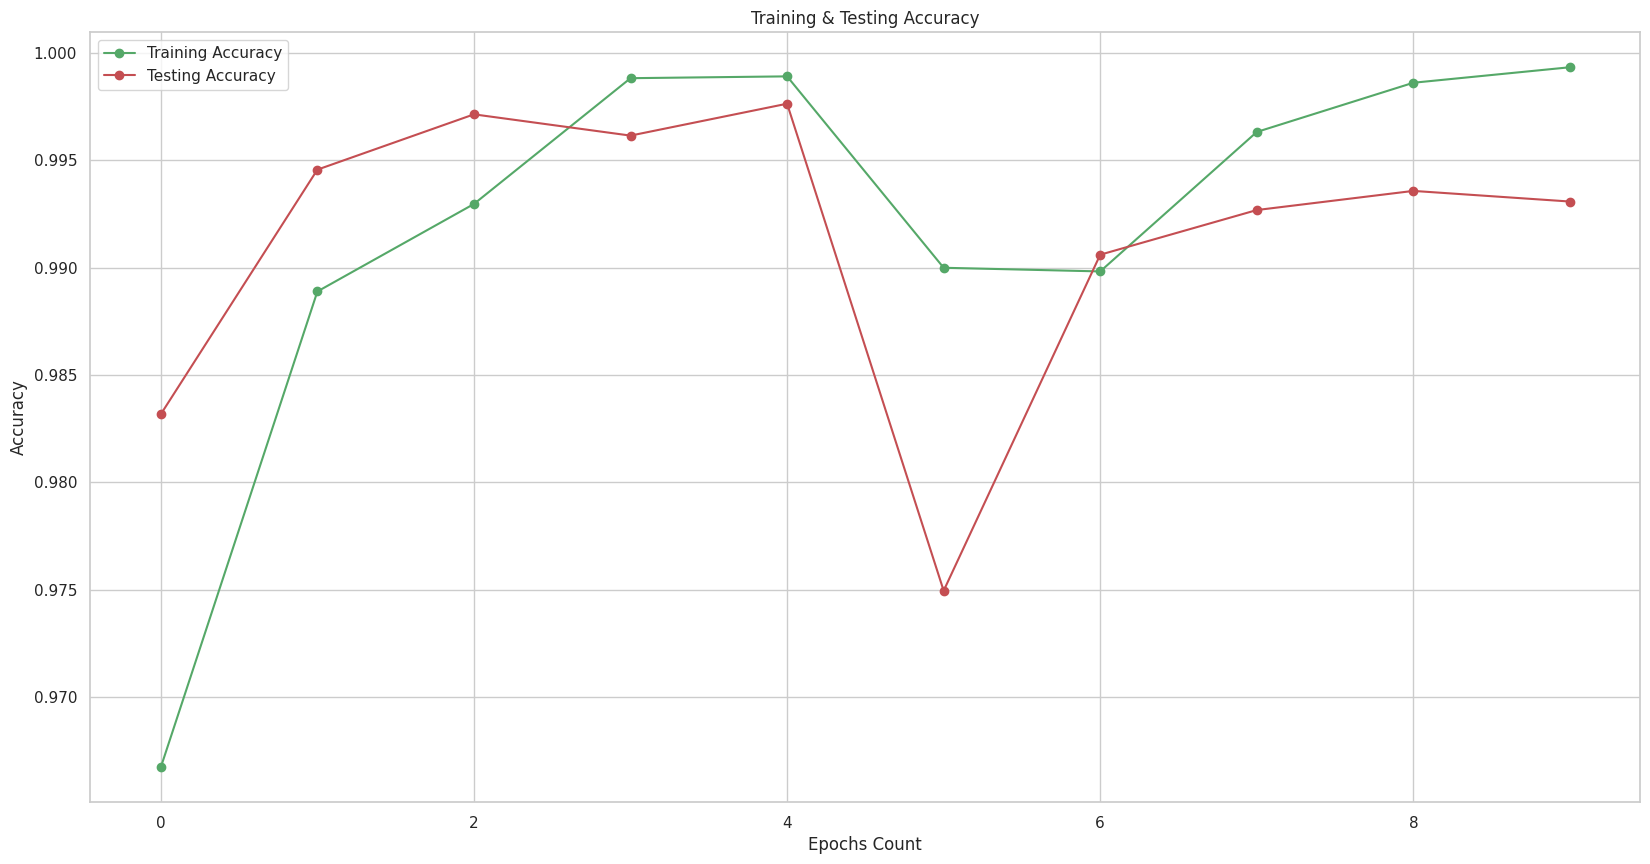

In [74]:
plotted_figure, ax = plt.subplots(1)
plotted_figure.set_size_inches(20,10)

ax.plot(epochs_count , accuracy_training , 'go-' , label = 'Training Accuracy')
ax.plot(epochs_count , accuracy_validation , 'ro-' , label = 'Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs Count")
ax.set_ylabel("Accuracy")

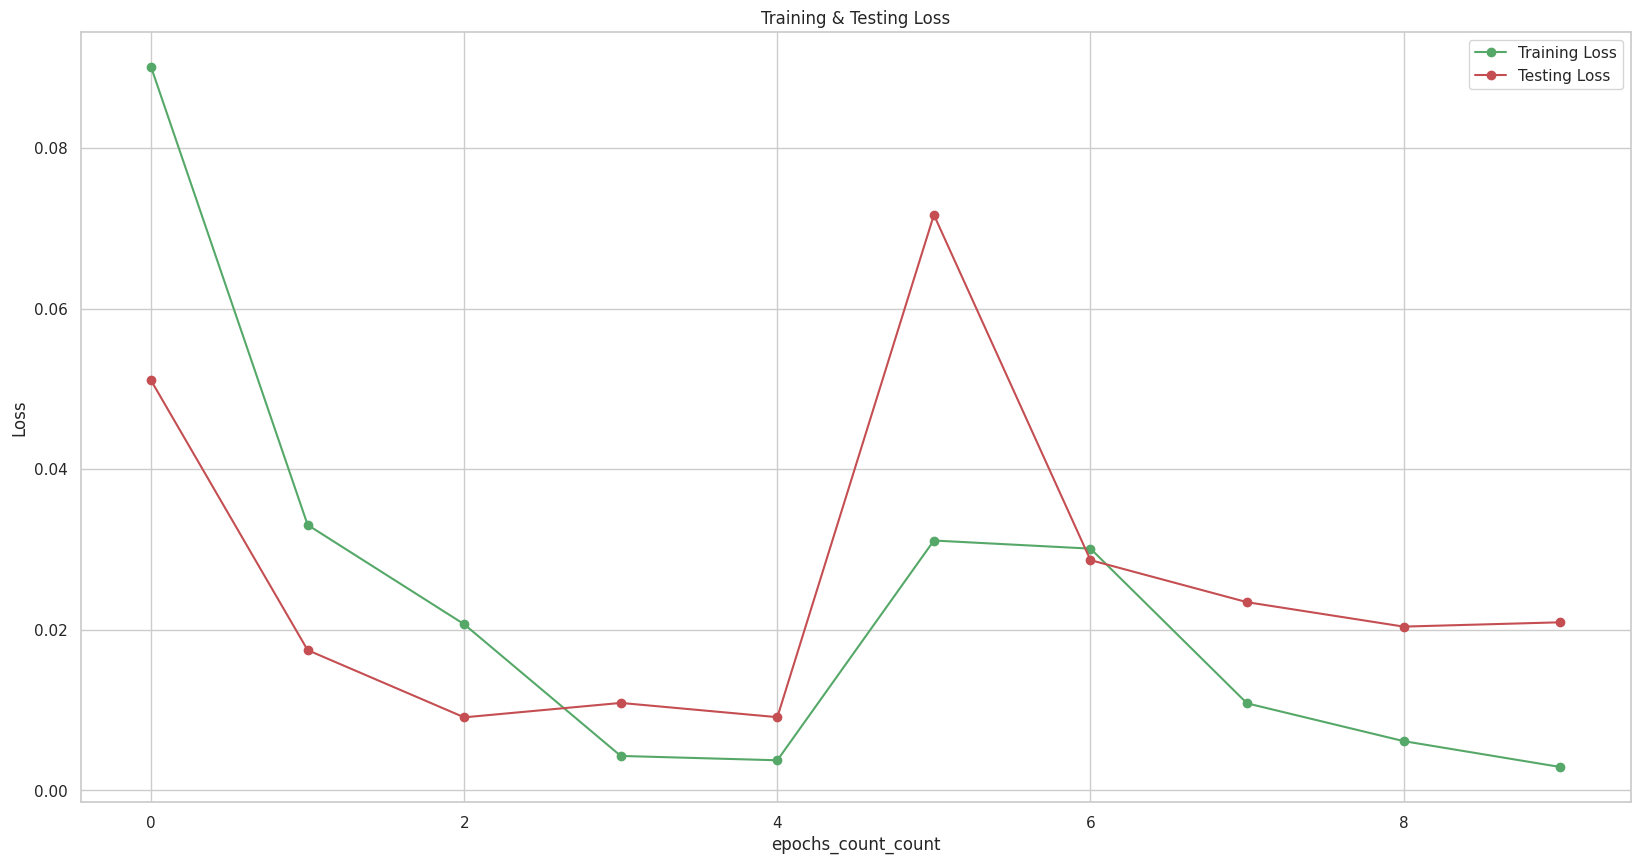

In [75]:
plotted_figure, ax = plt.subplots(1)
plotted_figure.set_size_inches(20,10)

ax.plot(epochs_count , loss_training , 'go-' , label = 'Training Loss')
ax.plot(epochs_count , loss_validation , 'ro-' , label = 'Testing Loss')
ax.set_title('Training & Testing Loss')
ax.legend()
ax.set_xlabel("epochs_count_count")
ax.set_ylabel("Loss")
plt.show()

351/351 [==============================] - 3s 9ms/step


Text(91.25, 0.5, 'Actual')

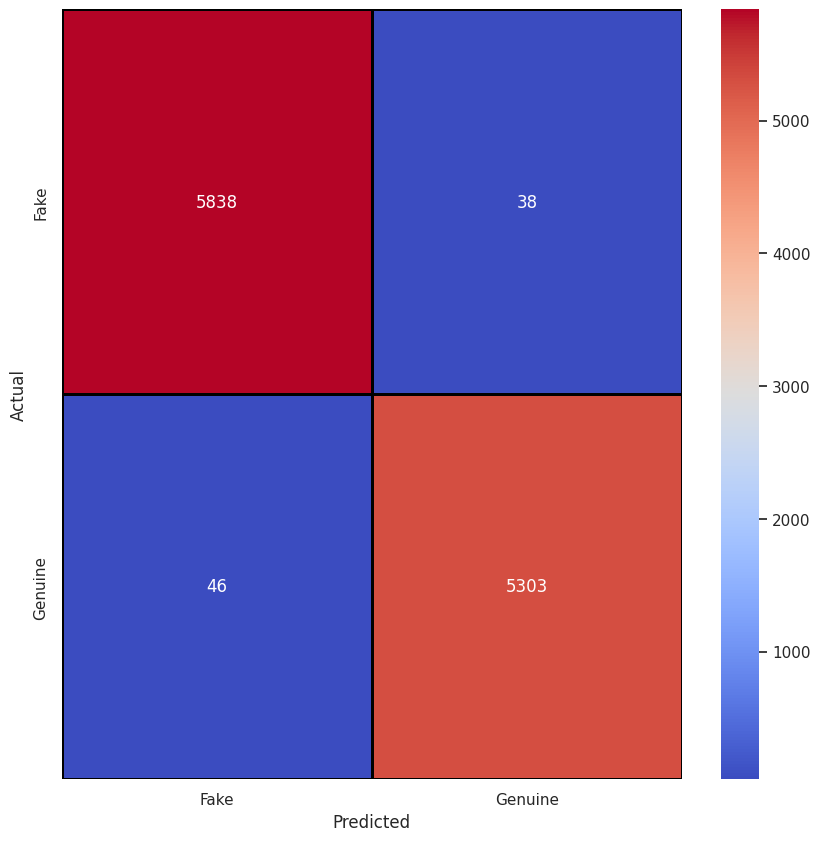

In [76]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

classification_summary = classification_report(y_test, predictions, target_names=['Fake', 'Genuine'])

confusion_matrix_results = confusion_matrix(y_test, predictions)

confusion_matrix_df = pd.DataFrame(
    confusion_matrix_results,
    index=['Fake', 'Genuine'],
    columns=['Fake', 'Genuine']
)

plt.figure(figsize=(10, 10))

sns.set(style="whitegrid")  # Set the style for the plot

sns.heatmap(
    confusion_matrix_df, cmap="coolwarm",
    linecolor='black',
    linewidth=1,
    annot=True,
    fmt='d',
    xticklabels=['Fake', 'Genuine'],
    yticklabels=['Fake', 'Genuine']
)

plt.xlabel("Predicted")
plt.ylabel("Actual")


# 2 XGBoost using Roberta 

In [77]:
!pip install transformers
import transformers

roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base-openai-detector')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import tqdm

def tokenize_documents(tokenizer_instance, documents):
    tokenized_features = []
    for document in tqdm.tqdm(documents, desc='Converts it to features'):
        tokenized_doc = tokenizer_instance.tokenize(document)
        id_list = tokenizer_instance.convert_tokens_to_ids(tokenized_doc)
        tokenized_features.append(id_list)
    return tokenized_features


In [79]:
x_train, x_test,y_train,y_test = train_test_split(
    genuine_and_fake_news_df.text, 
    genuine_and_fake_news_df.category, 
    random_state=0
)

In [80]:
roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base-openai-detector')

In [81]:
roberta_feature_training = tokenize_documents(roberta_tokenizer, x_train)
roberta_feature_testing = tokenize_documents(roberta_tokenizer, x_test)

Converts it to features: 100%|██████████| 11225/11225 [00:22<00:00, 488.13it/s]


In [82]:
from keras.utils import pad_sequences

training_rb = pad_sequences(roberta_feature_training, maxlen = 500)
testing_rb = pad_sequences(roberta_feature_testing, maxlen = 500)

In [83]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.15,
    max_depth=9,
    eval_metric="auc",
    use_label_encoder=False,
    objective="binary:logistic",
)
xgb.fit(training_rb, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [84]:
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_prediction = xgb.predict(testing_rb)
score_xgb = accuracy_score(y_test, xgb_prediction)
xgb_roc = roc_auc_score(y_test, xgb_prediction)


print("The accuracy of XGBOOST is: %0.2f" %score_xgb)
print("The roc_auc score of XGBOOST is: %0.2f" %xgb_roc)

The accuracy of XGBOOST is: 0.98
The roc_auc score of XGBOOST is: 0.98


In [85]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, xgb_prediction)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5858
           1       0.98      0.98      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



## CatBoost using Roberta

In [86]:
cb = CatBoostClassifier(eval_metric = 'Accuracy', iterations = 2000, learning_rate = 0.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 23.8 MB/s eta 0:00:00


In [87]:
cb.fit(training_rb, y_train, verbose = 0)
catboost_predicted = cb.predict(testing_rb)
score_catboost = accuracy_score(y_test, catboost_predicted)
catboost_roc = roc_auc_score(y_test, catboost_predicted)


print("The accuracy of CatBoost is: %0.2f" %score_catboost)
print("The roc_auc score of CatBoost is: %0.2f" %catboost_roc)

The accuracy of CatBoost is: 0.98
The roc_auc score of CatBoost is: 0.98


In [88]:
from sklearn.metrics import classification_report
classification_report_two = classification_report(y_test, catboost_predicted)
print(classification_report_two)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5858
           1       0.98      0.98      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



#2. RNN Model

In [89]:
x_train, x_test,y_train,y_test = train_test_split(
    genuine_and_fake_news_df.text, 
    genuine_and_fake_news_df.category, 
    random_state=0
)

In [90]:
maximum_number_features = 10000

In [91]:
maxlen = 300

In [92]:
text_tokenizer = text.Tokenizer(num_words=maximum_number_features)

In [93]:
text_tokenizer.fit_on_texts(x_train)

In [94]:
tokenized_train = text_tokenizer.texts_to_sequences(x_train)

In [95]:
x_train = pad_sequences(tokenized_train, maxlen=300)

In [96]:
tokenized_text = text_tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(
    tokenized_text, 
    maxlen=300
)

In [97]:
def retreive_coefficients(word, *word_list): 
    return word, np.asarray(word_list, dtype='float32')


In [98]:
glove_embedding_vector_position = dict(
    retreive_coefficients(*_opened_text.rstrip().rsplit(' ')) for _opened_text in open('/content/drive/MyDrive/Datasets/FakeNews/glove.twitter.27B.100d.txt')
)

In [99]:
embedding_using_glove = np.stack(
    glove_embedding_vector_position.values()
)

size_of_embedding = embedding_using_glove.shape[1]

word_position = text_tokenizer.word_index

embedding_words = min(
    maximum_number_features, 
    len(word_position)
)

In [100]:
embedding_matrices  = np.random.normal(
    embedding_using_glove.mean(), 
    embedding_using_glove.std(), 
    (embedding_words, size_of_embedding)
)  

In [101]:
for word, index in word_position.items():

    if(index >= maximum_number_features): 
      continue

    glove_embedding_vector = glove_embedding_vector_position.get(word)

    if(glove_embedding_vector is not None): 
      embedding_matrices[index] = glove_embedding_vector

In [102]:
size_of_batch = 256
epochs_count = 10
size_of_embedding = 100

In [103]:
reduce_rate_of_learning = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1,
    factor=0.5, 
    min_lr=0.00001
)

In [104]:
sequential_model = Sequential()

sequential_model.add(
    Embedding(
        maximum_number_features, 
        output_dim=size_of_embedding, 
        weights=[embedding_matrices], 
        input_length=maxlen, 
        trainable=False
    )
)

sequential_model.add(
    LSTM(
        units=128, 
         return_sequences=True,
         recurrent_dropout=0.25,
         dropout=0.25
    )
)

sequential_model.add(
    LSTM(
        units=64, 
        recurrent_dropout=0.1,
        dropout = 0.1
    )
)

sequential_model.add(
    Dense(
        units=32, 
        activation='relu'
    )
)

sequential_model.add(
    Dense(
        1, 
        activation='sigmoid'
    )
)

sequential_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

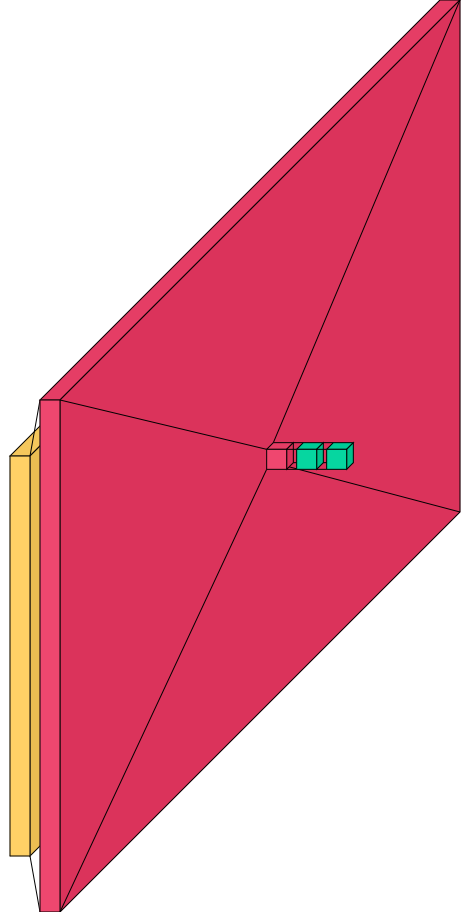

In [105]:
visualkeras.layered_view(sequential_model)

In [106]:
sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [107]:
sequential_model_history = sequential_model.fit(
    x_train, 
    y_train, 
    batch_size=size_of_batch, 
    validation_data=(X_test, y_test), 
    epochs=5,
    callbacks=[reduce_rate_of_learning]
)

Epoch 1/5
132/132 [==============================] - 239s 2s/step - loss: 0.1603 - accuracy: 0.9351 - val_loss: 0.3340 - val_accuracy: 0.9060 - lr: 0.0100
Epoch 2/5
132/132 [==============================] - 235s 2s/step - loss: 0.0401 - accuracy: 0.9859 - val_loss: 0.0190 - val_accuracy: 0.9928 - lr: 0.0100
Epoch 3/5
132/132 [==============================] - 235s 2s/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0204 - val_accuracy: 0.9937 - lr: 0.0100
Epoch 4/5
132/132 [==============================] - 235s 2s/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0115 - val_accuracy: 0.9966 - lr: 0.0100
Epoch 5/5
132/132 [==============================] - 234s 2s/step - loss: 0.0804 - accuracy: 0.9713 - val_loss: 0.1169 - val_accuracy: 0.9547 - lr: 0.0100


# III. Critical Evaluation

In [108]:
print("Training Data's Accuracy - " , sequential_model.evaluate(x_train, y_train)[1]*100, "%")

1053/1053 [==============================] - 179s 170ms/step - loss: 0.1146 - accuracy: 0.9566
Training Data's Accuracy -  95.65824270248413 %


In [109]:
print("Testing Data's Accuracy" , sequential_model.evaluate(X_test,y_test)[1]*100, "%")

351/351 [==============================] - 60s 170ms/step - loss: 0.1169 - accuracy: 0.9547
Testing Data's Accuracy 95.46548128128052 %


In [110]:
epochs_count = [index for index in range(5)]

accuracy_training = sequential_model_history.history[
    'accuracy'
]

loss_training = sequential_model_history.history[
    'loss'
]

accuracy_validation = sequential_model_history.history[
    'val_accuracy'
]

loss_validation = sequential_model_history.history[
    'val_loss'
]

Text(0, 0.5, 'Accuracy')

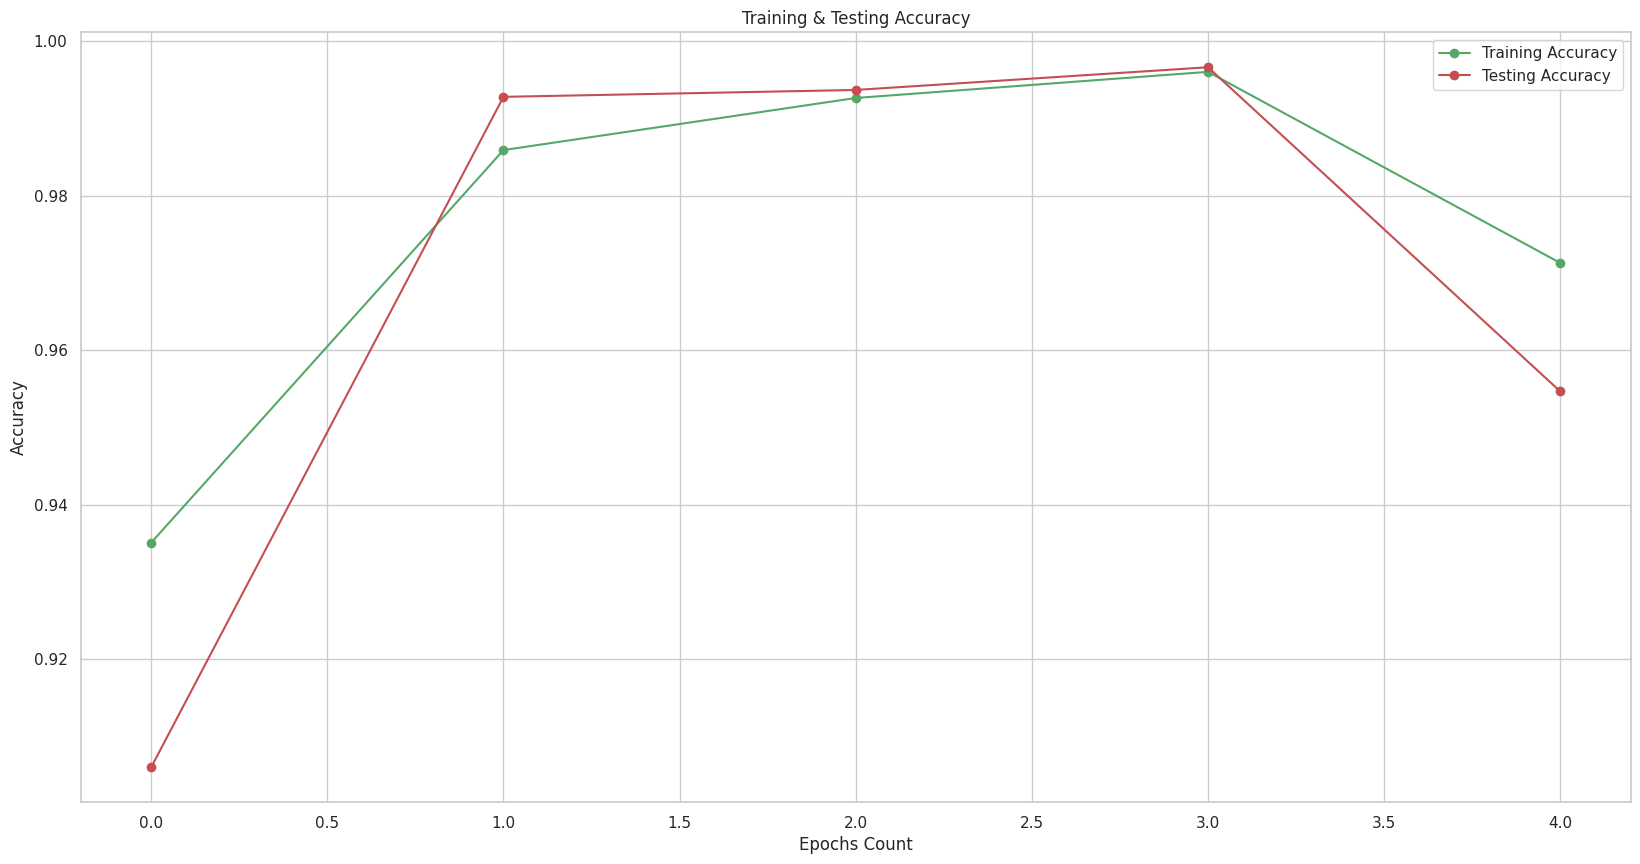

In [111]:
plotted_figure, ax = plt.subplots(1)
plotted_figure.set_size_inches(20,10)

ax.plot(epochs_count , accuracy_training , 'go-' , label = 'Training Accuracy')
ax.plot(epochs_count , accuracy_validation , 'ro-' , label = 'Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs Count")
ax.set_ylabel("Accuracy")

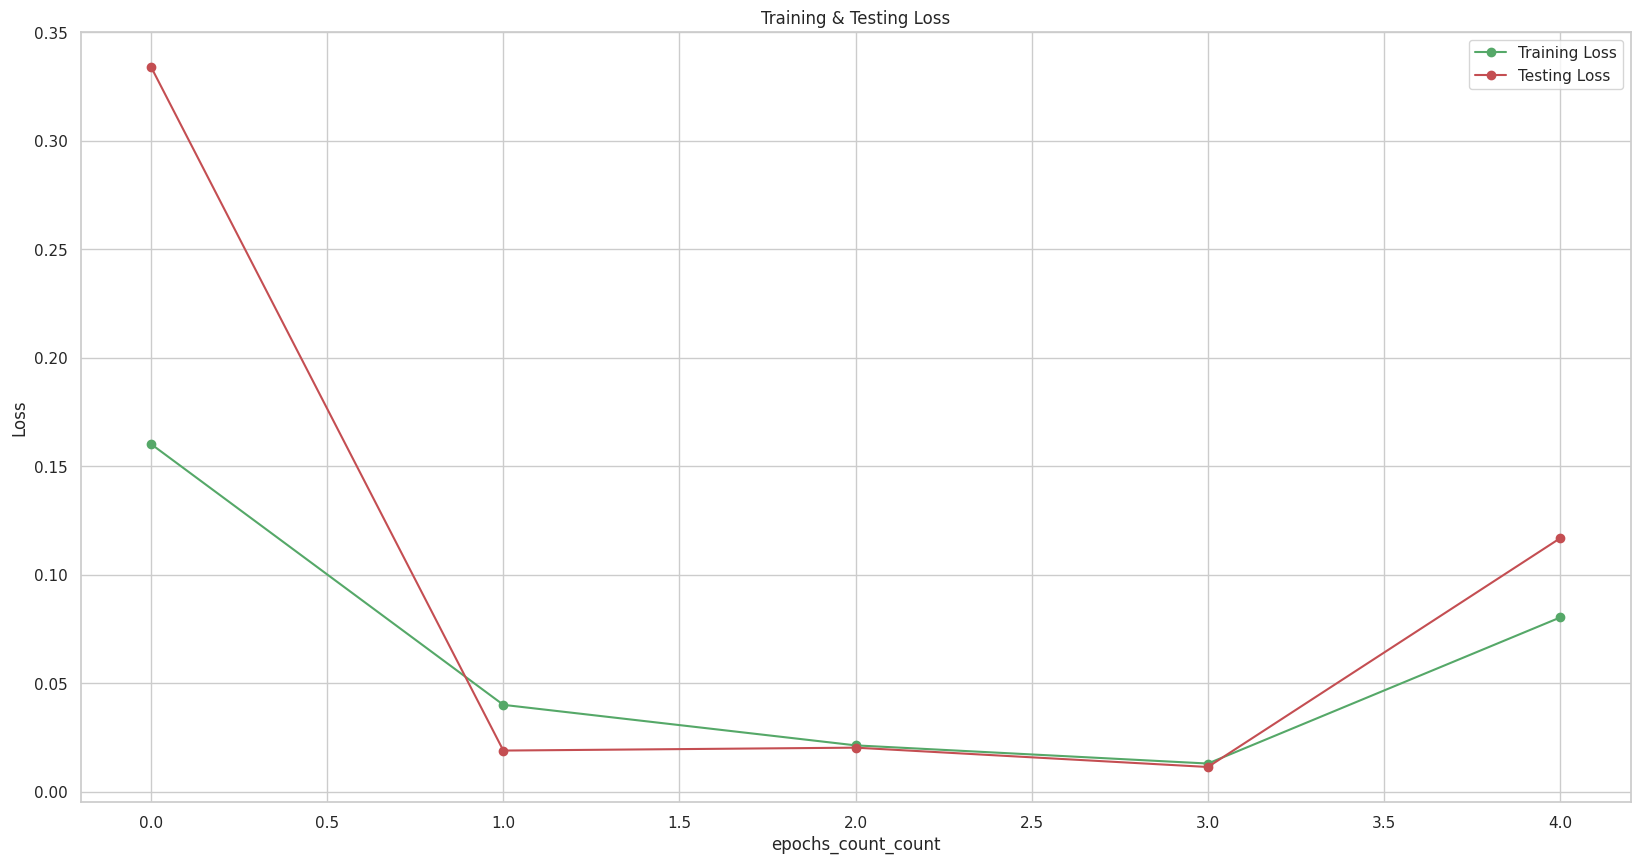

In [112]:
plotted_figure, ax = plt.subplots(1)
plotted_figure.set_size_inches(20,10)

ax.plot(epochs_count , loss_training , 'go-' , label = 'Training Loss')
ax.plot(epochs_count , loss_validation , 'ro-' , label = 'Testing Loss')
ax.set_title('Training & Testing Loss')
ax.legend()
ax.set_xlabel("epochs_count_count")
ax.set_ylabel("Loss")
plt.show()

In [113]:
predicted = (sequential_model.predict(X_test) > 0.5).astype("int32")

351/351 [==============================] - 60s 169ms/step


In [114]:
classfication_data = classification_report(y_test, predicted, target_names = ['Fake','Genuine'])

In [115]:
print(classfication_data)

              precision    recall  f1-score   support

        Fake       0.96      0.95      0.96      5858
     Genuine       0.94      0.96      0.95      5367

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



In [116]:
confusion_matrix_result = confusion_matrix(y_test, predicted)

In [117]:
confusion_matrix_dataframe = pd.DataFrame(
    confusion_matrix_result, 
    index=['Fake','Genuine'],
    columns=['Fake','Genuine']
)

Text(91.25, 0.5, 'Actual')

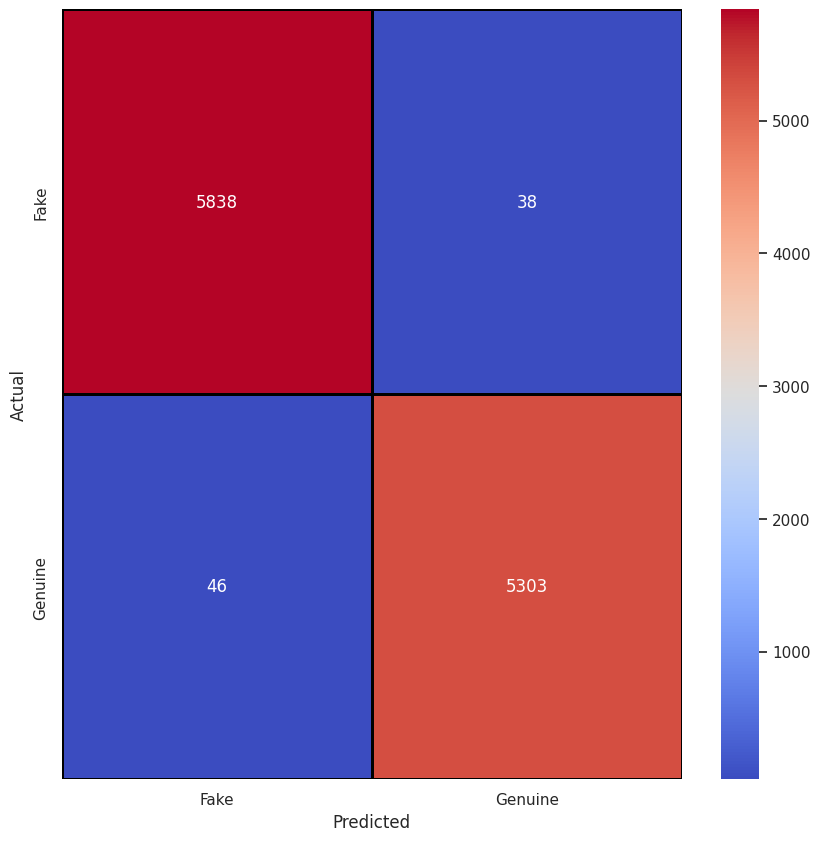

In [118]:
plt.figure(figsize = (10,10))

sns.heatmap(
    confusion_matrix_df, cmap="coolwarm",
    linecolor='black',
    linewidth=1,
    annot=True,
    fmt='d',
    xticklabels=['Fake', 'Genuine'],
    yticklabels=['Fake', 'Genuine']
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
